In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [43]:
import cv2
import numpy as np                                                              
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf                                                         
import scipy as sp
import data.data_selector as ds                                                   
import utils.data_processing as dp
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap

In [3]:
class params(object):
  def __init__(self):
    self.model_type = "ica_subspace"
    self.model_name = "ica_subspace_vh"
    self.version = "3"
    self.save_info = "analysis_train"
    self.overwrite_analysis_log = False
analysis_params = params()
analysis_params.project_dir = (os.path.expanduser("~")+"/Work/Projects/")
analysis_params.model_dir = (analysis_params.project_dir+analysis_params.model_name)

analyzer = ap.get_analyzer(analysis_params.model_type)
analyzer.setup(analysis_params)
analyzer.setup_model(analyzer.model_params)
analyzer.load_analysis(save_info=analysis_params.save_info)
analyzer.model_name = analysis_params.model_name

In [4]:
dataset = ds.get_data(analyzer.model_params)
dataset = analyzer.model.preprocess_dataset(dataset, analyzer.model_params)
dataset = analyzer.model.reshape_dataset(dataset, analyzer.model_params)

INFO:preprocessing:Low pass filtered train data
INFO:preprocessing:Extracted patches from train data
INFO:preprocessing:Whitened train data
INFO:preprocessing:Centered train data


In [46]:
def get_info(analyzer, inputs):
    with tf.Session(graph=analyzer.model.graph) as sess:
        sess.run(analyzer.model.init_op)
        feed_dict = analyzer.model.get_feed_dict(inputs)
        analyzer.model.load_full_model(sess, analyzer.analysis_params.cp_loc)
        latent_vars = sess.run(analyzer.model.s, feed_dict)
        w_synth = sess.run(analyzer.model.w_synth, feed_dict)
        w_analy = sess.run(analyzer.model.w_analy, feed_dict)
        recon = sess.run(analyzer.model.recon, feed_dict)
    return latent_vars, w_synth, w_analy, recon

def get_group_act(s, group_size=4):
    num_groups = s.shape[1]//group_size
    group_acts = []
    for i in range(s.shape[0]):
        groups = np.array(np.array_split(s[i], s.shape[1]//group_size))
        group_act = np.sqrt(np.sum(np.power(groups, 2), axis=1))
        group_acts.append(group_act)
    return np.stack(group_acts)

In [21]:
latent_vars, w_synth, w_analy, recon = get_info(analyzer)
group_acts = get_group_act(latent_vars)

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/ica_subspace_vh/checkpoints/ica_subspace_vh_v3-17000


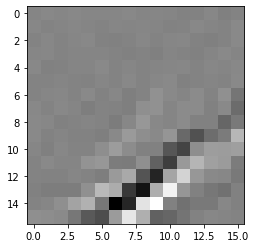

In [22]:
plt.imshow(w_analy[:, 59].reshape(16, 16), cmap="gray")

In [35]:
def show_recon(i):
    fig, ax = plt.subplots(ncols=2, nrows=1)
    ax[0].imshow(recon[i].reshape(16, 16), cmap="gray")
    ax[0].set_title("reconstruction")
    ax[1].imshow(dataset["train"].images[i].reshape(16, 16), cmap="gray")
    ax[1].set_title("original")
    plt.show()

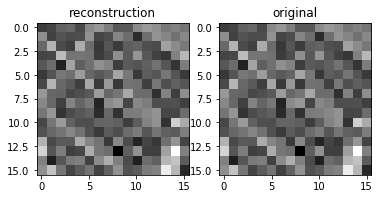

In [38]:
show_recon(4)

In [40]:
analyzer.bf_stats.keys()

dict_keys(['basis_functions', 'envelopes', 'gauss_fits', 'gauss_centers', 'gauss_orientations', 'areas', 'fourier_centers', 'fourier_maps', 'num_inputs', 'spatial_frequencies', 'envelope_centers', 'num_outputs', 'patch_edge_size', 'phases', 'ellipse_orientations', 'diameters'])

In [41]:
vid_paths = [os.path.join("/home/ryanchan/Work/BIRD_vids",name) for name in os.listdir("/home/ryanchan/Work/BIRD_vids")]
vid_paths

['/home/ryanchan/Work/BIRD_vids/GP005_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP006_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP003_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP008_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP007_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP001_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP002_gray_dn64x.mp4']

In [93]:
# read video from file 
# Path to video file 
vidObj = cv2.VideoCapture(vid_paths[0]) 
success = True
frames = []
count = 0
while success and count < 256:
    success, image = vidObj.read() 
    if success:
        frames.append(image)
    count += 1
frames = (np.stack(frames) / 255.)[:, :100, :100, :1]

In [94]:
def get_info(analyzer, inputs):
    with tf.Session(graph=analyzer.model.graph) as sess:
        sess.run(analyzer.model.init_op)
        feed_dict = analyzer.model.get_feed_dict(inputs)
        analyzer.model.load_full_model(sess, analyzer.analysis_params.cp_loc)
        latent_vars = sess.run(analyzer.model.s, feed_dict)
        w_synth = sess.run(analyzer.model.w_synth, feed_dict)
        w_analy = sess.run(analyzer.model.w_analy, feed_dict)
        recon = sess.run(analyzer.model.recon, feed_dict)
    return latent_vars, w_synth, w_analy, recon

def get_group_act(s, group_size=4):
    num_groups = s.shape[1]//group_size
    group_acts = []
    for i in range(s.shape[0]):
        groups = np.array(np.array_split(s[i], s.shape[1]//group_size))
        group_act = np.sqrt(np.sum(np.power(groups, 2), axis=1))
        group_acts.append(group_act)
    return np.stack(group_acts)

def get_recon_images(analyzer, full_images):
    wht_img, img_mean, ft_filter = dp.whiten_data(full_images,
        method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
    img_patches = wht_img[:, 20:20+16, 20:20+16, :]
    return img_patches



In [105]:
img_patches = get_recon_images(analyzer, frames)
reshaped_img_patches = img_patches.reshape(-1, 256)
latent_vars, w_synth, w_analy, recon = get_info(analyzer, reshaped_img_patches)
group_act = get_group_act(latent_vars)

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/ica_subspace_vh/checkpoints/ica_subspace_vh_v3-17000


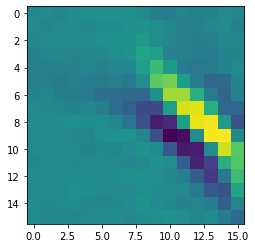

In [100]:
plt.imshow(w_analy[:, 0].reshape(16, 16))

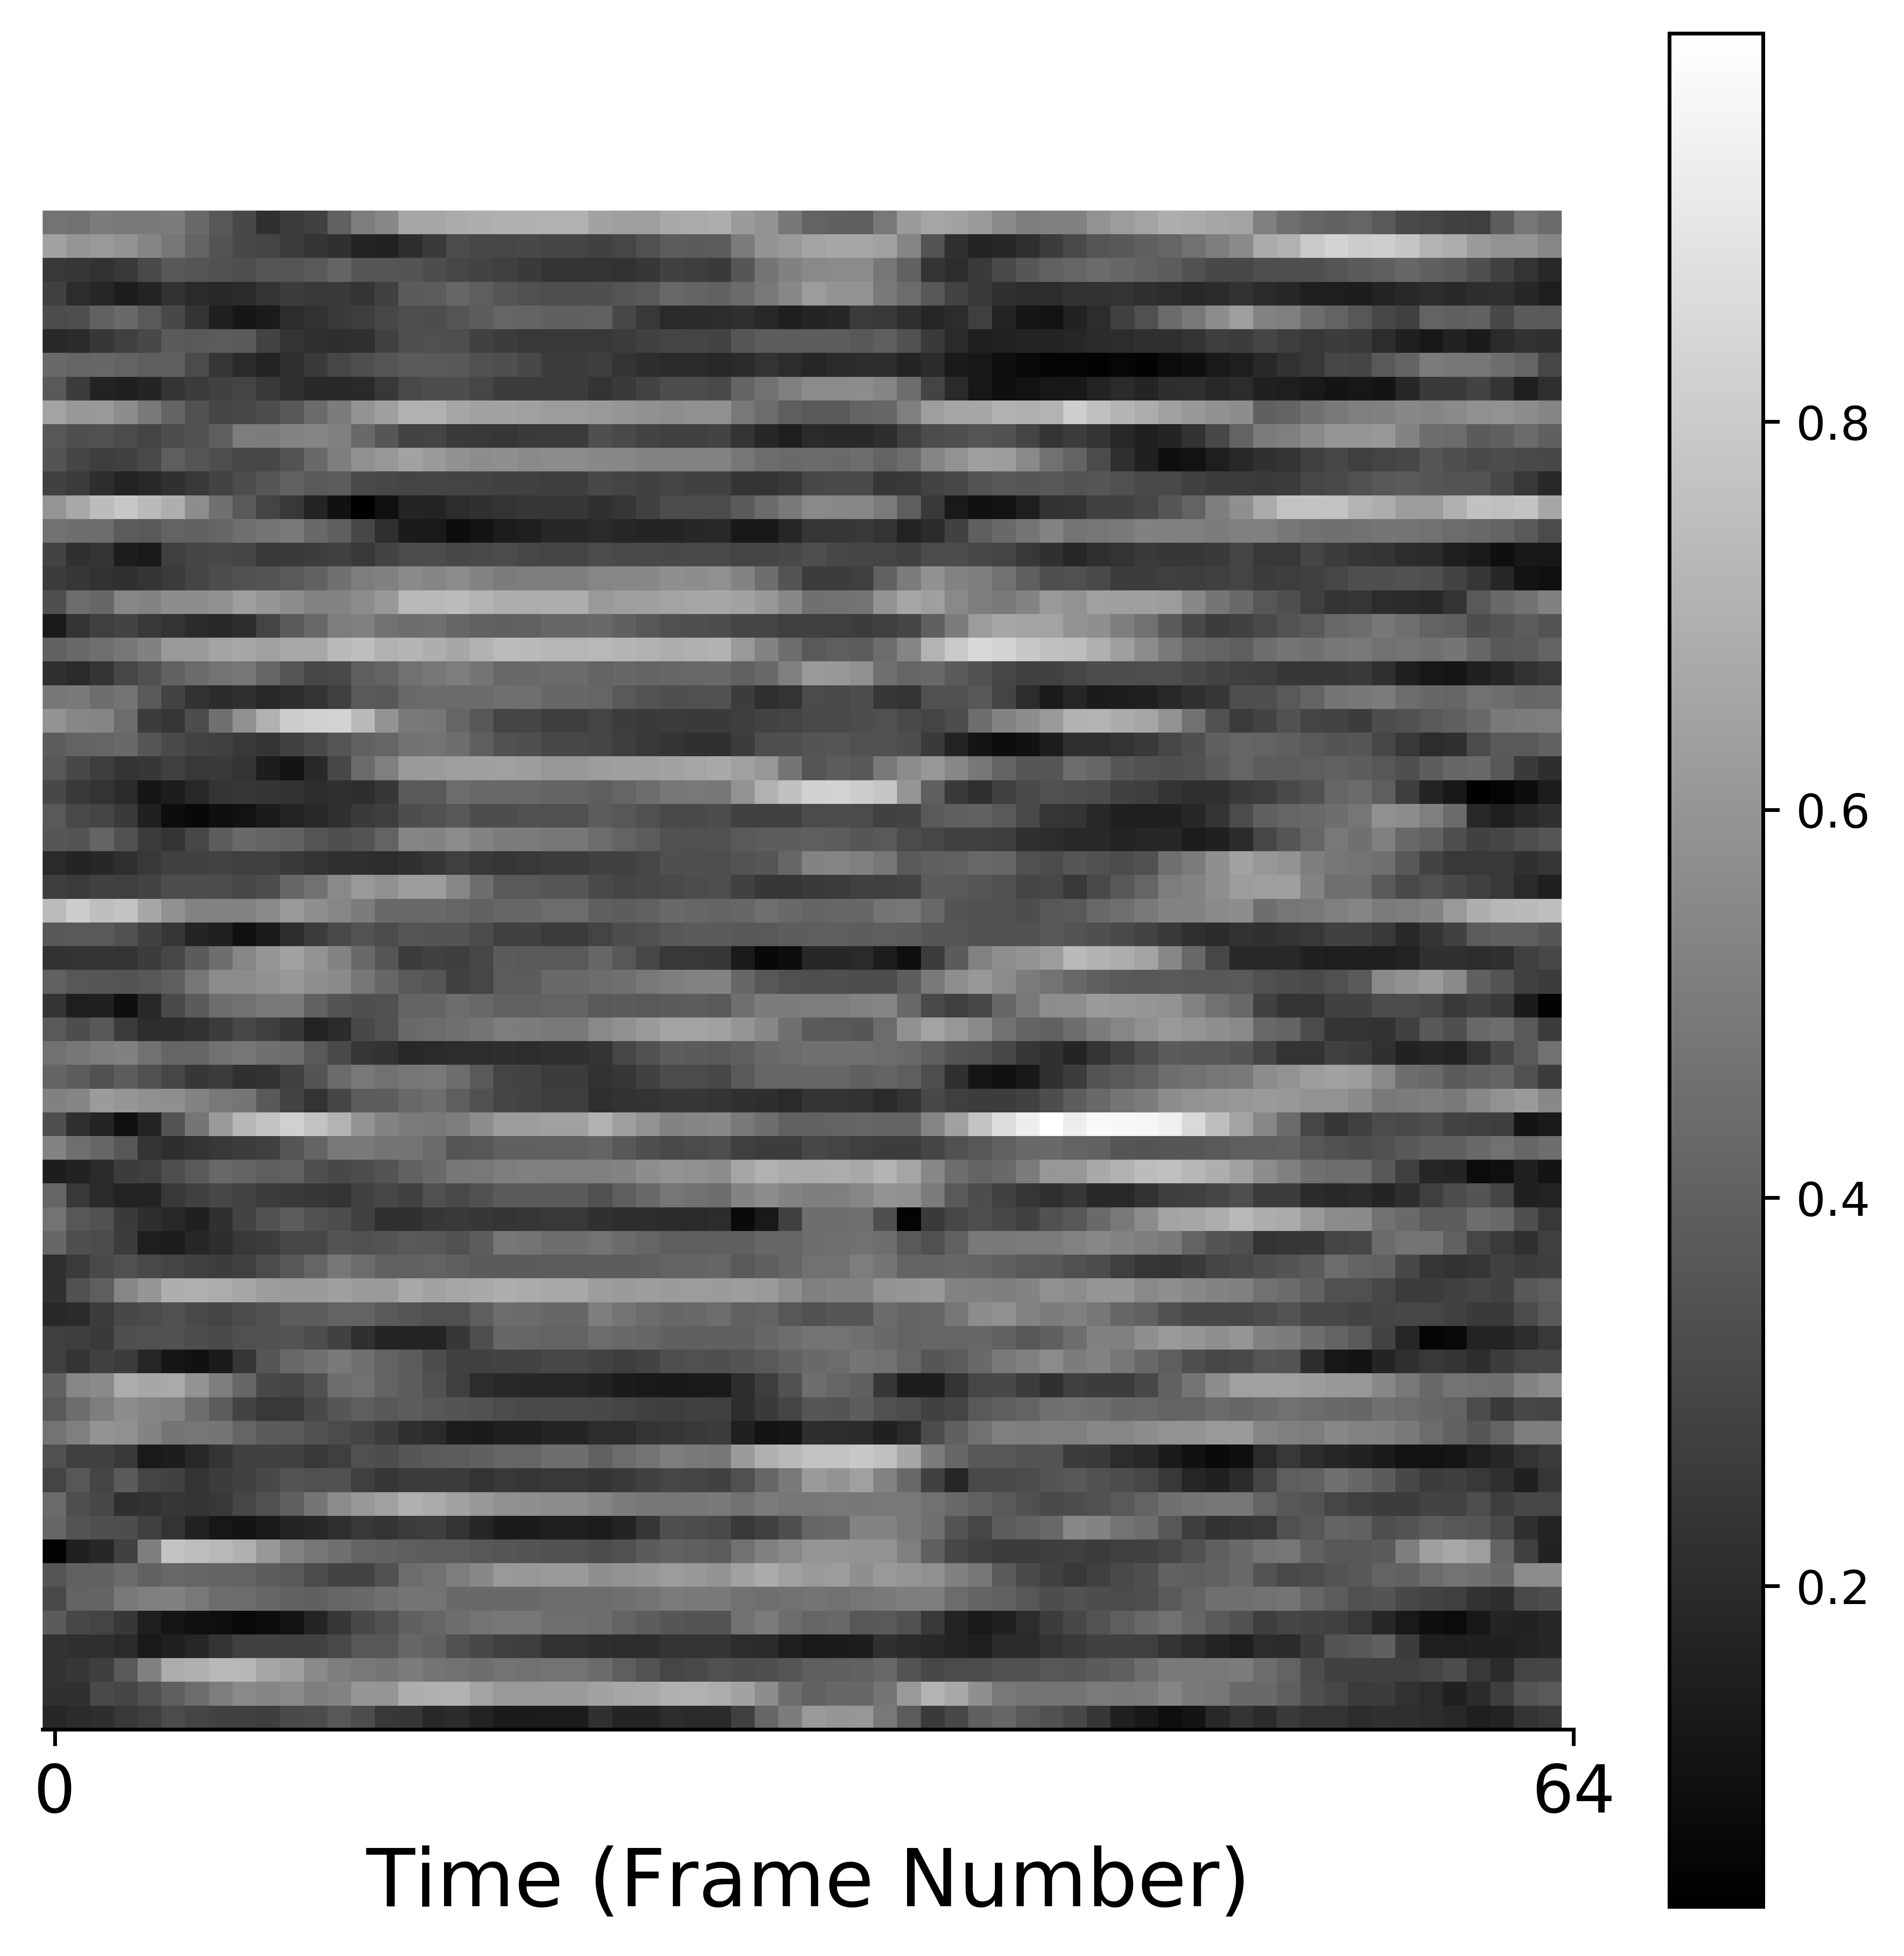

In [109]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), dpi=800)
x = np.abs(group_act.T)
x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
im = ax.imshow(x[:64, :64], cmap="gray")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([0, len(x)])
ax.set_yticks([])
ax.set_xlabel("Time (Frame Number)", fontsize=17)
plt.colorbar(im)
ax.tick_params(labelsize=14)
fig.tight_layout()

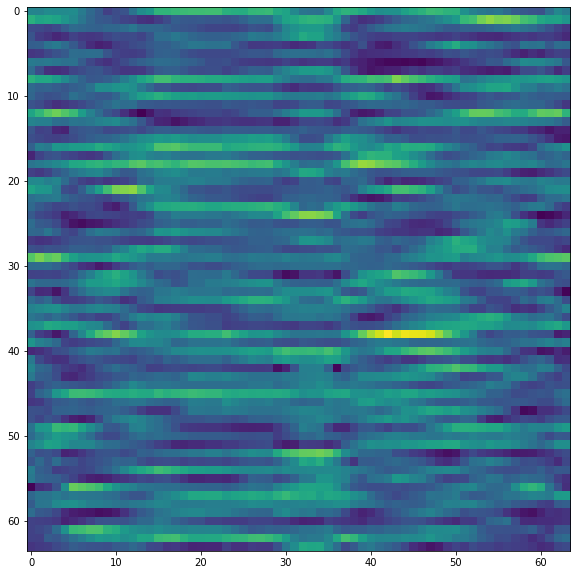

In [67]:
plt.figure(figsize=(10, 10))
plt.imshow(group_acts.T)